# **Importación de paquetes**

In [1]:
import pandas as pd
import numpy as np


from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder,RobustScaler,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from Machine_Learning_Tools.plots import *
from imblearn.combine import SMOTEENN
import keras_tuner as kt

from Machine_Learning_Tools.Neural_Networks_Models import multi_layer_perceptron

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook',style='whitegrid',palette='nipy_spectral',font_scale=1.5)
%matplotlib inline

# **Análisis exploratorio de los datos**

In [2]:
df = pd.read_csv('datasets/bank-full.csv')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Información de las variables:

- age (numeric)
- job : tipo de trabajo (categorical:admin.','bluecollar','entrepreneur','housemaid','management','retired','selfemployed','services','student','technician','unemployed','unknown')
- marital : estado civil (categorical:'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: ¿Tiene un crédito en incumplimiento? (categorical: 'no','yes','unknown')
- balance: balance anual promedio en euros (numeric)
- housing: ¿Tiene un préstamo hipotecario? (categorical: 'no','yes','unknown')
- loan: ¿Tiene un préstamo personal? (categorical: 'no','yes','unknown')
- contact: tipo de comunicación del contacto (categorical:'cellular','telephone')
- day: último día de contacto del mes  (numeric 1 -31)
- month: último mes de contacto del año(categorical: 'jan', 'feb','mar', …, 'nov', 'dec')
- duration: duración del último contacto, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., ifduration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known.Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
- campaign: número  de contactos presentados durante esta campaña para este cliente(numeric, includes last contact)
- pdays: número de dias que pasarón posteriormente al último contacto del cliente de la campaña previa (numeric; 999 means client was not previously contacted)
- previous: número de contactos presentados antes de esta campaña para este cliente(numeric)
- poutcome: resultado de la campaña de marqueting previa (categorical: 'failure','nonexistent','success')
- target: has the client subscribed a term deposit? (binary:"yes","no")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [6]:
numeric_features = list(df.describe().columns)
cat_features = list(df.drop(numeric_features,axis=1).columns)

## **Variables categóricas** 

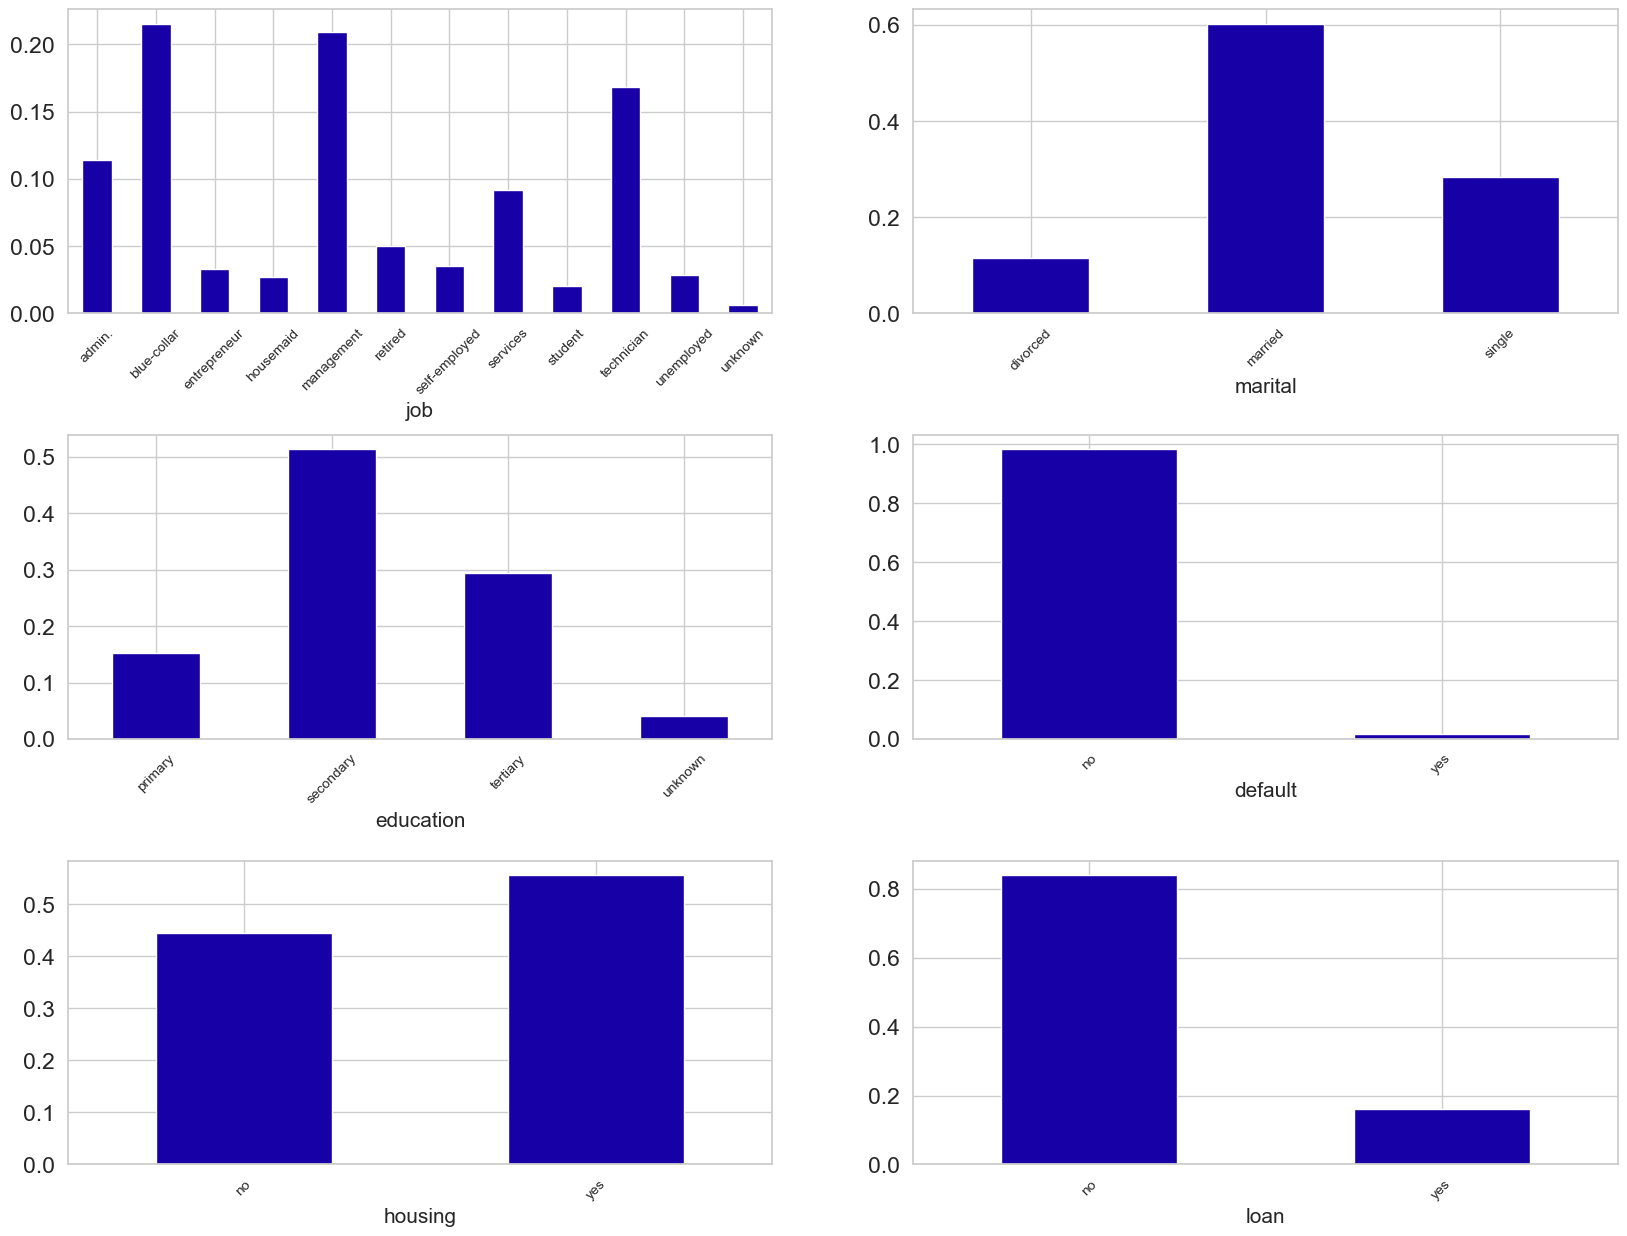

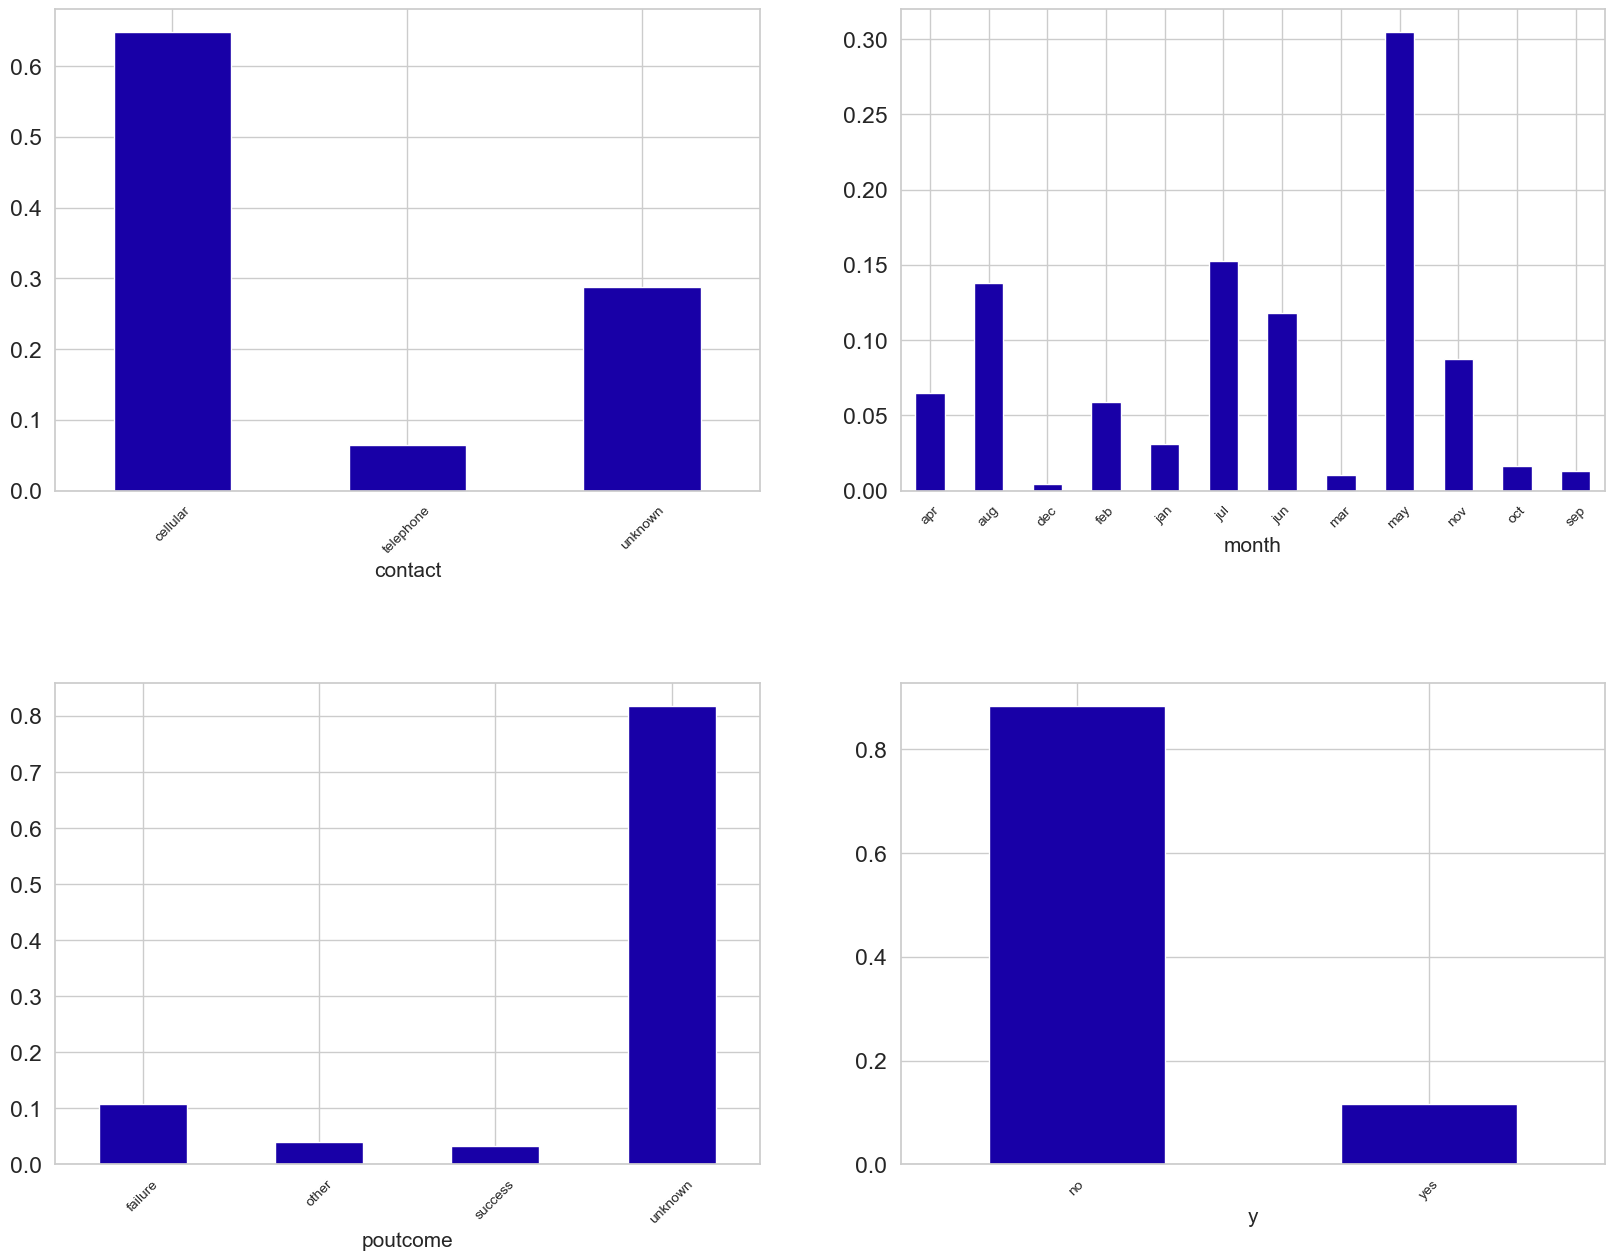

In [7]:
barplot1(df,cat_features[:6],rows=3,cols=2,figsize=(20,15),xticks_size=10)
barplot1(df,cat_features[6:],rows=2,cols=2,figsize=(20,15),xticks_size=10)

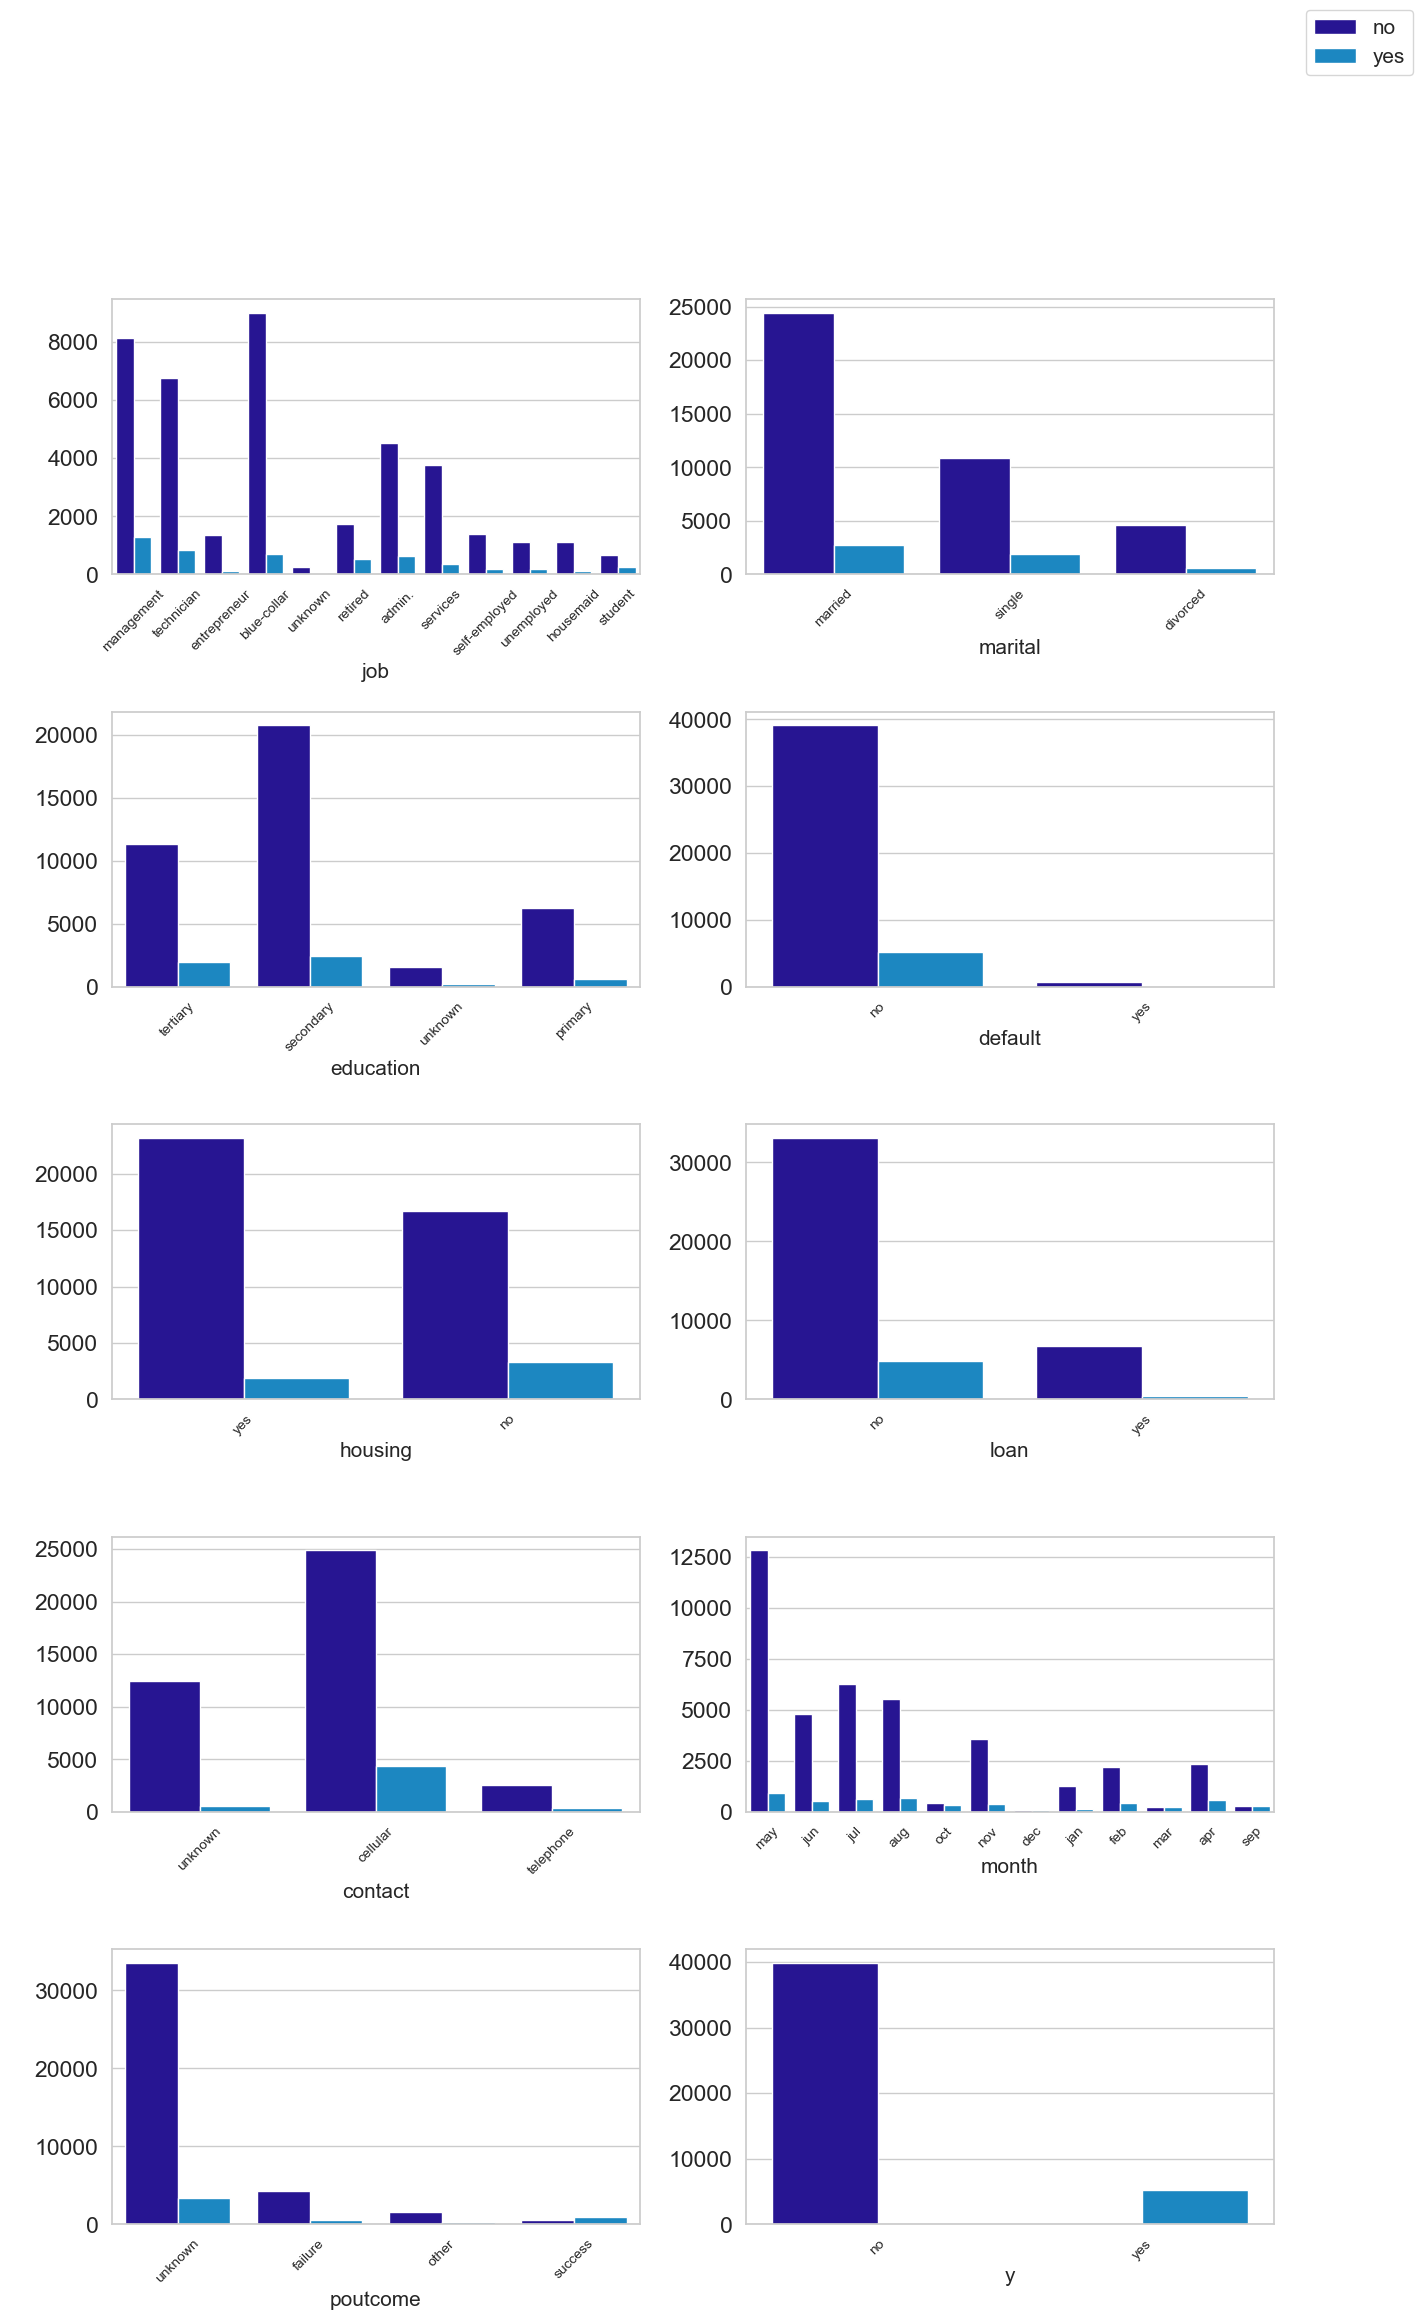

In [8]:
barplot2(df,cat_features,rows=5,cols=2,figsize=(15,25),hue='y',hspace=0.5)

Se puede observar que la variable que queremos predecir tiene un desbalanceo hacia el valor de $y = $ "no", esto puede ocasionar problemas, así es mejor utilizar técnicas para datos desbalanceados.

## **Variables numéricas**

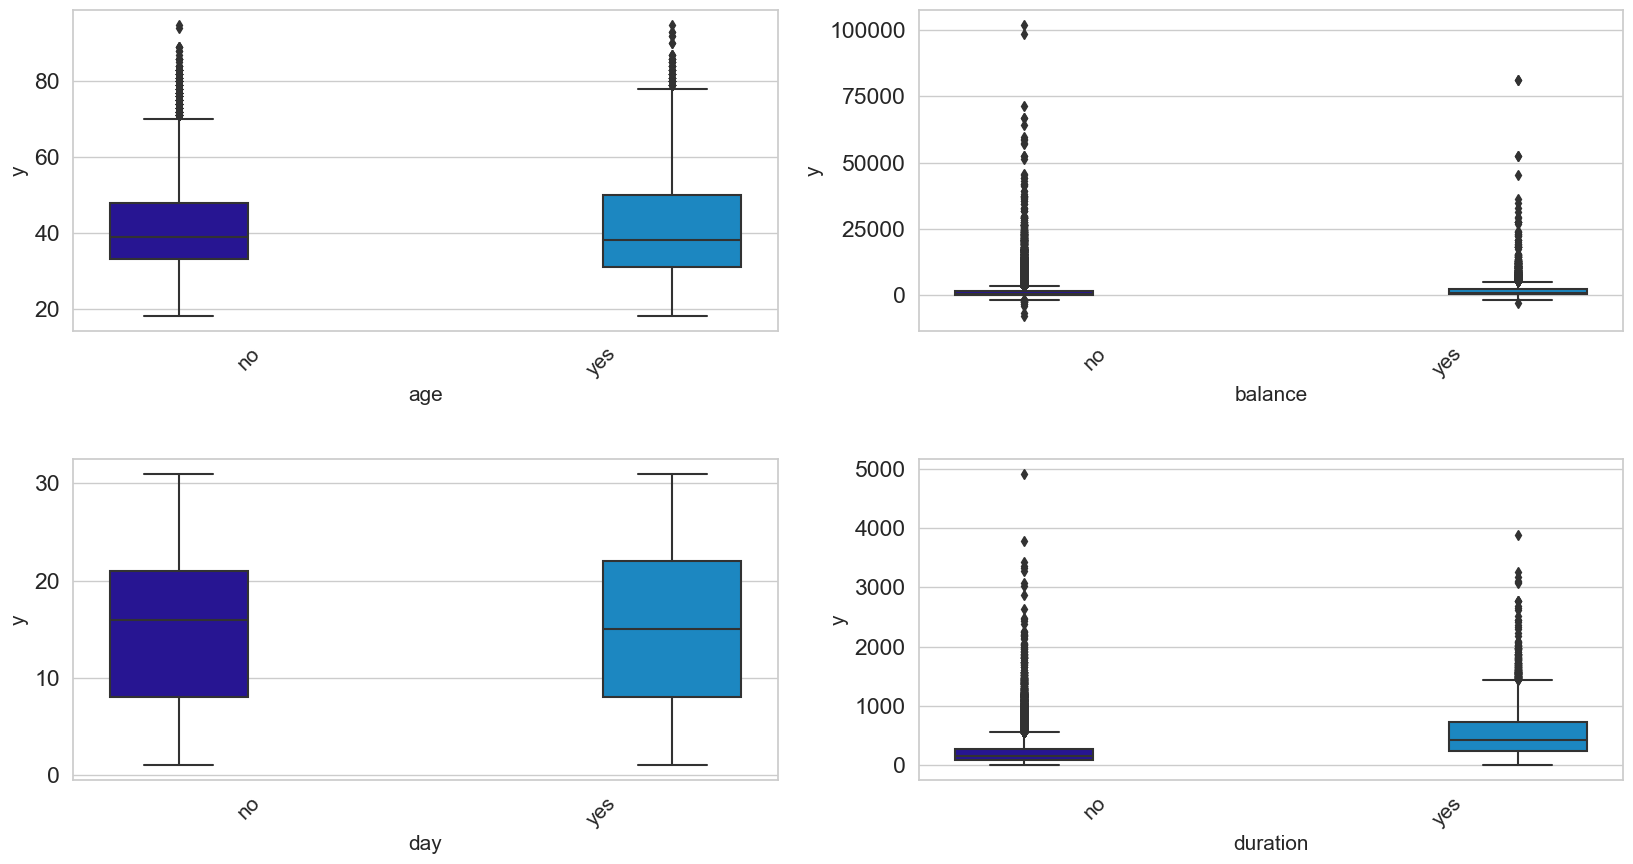

In [9]:
boxplot2(df,'y',numeric_features[:4],2,2,figsize=(20,10),xticks_size=15)

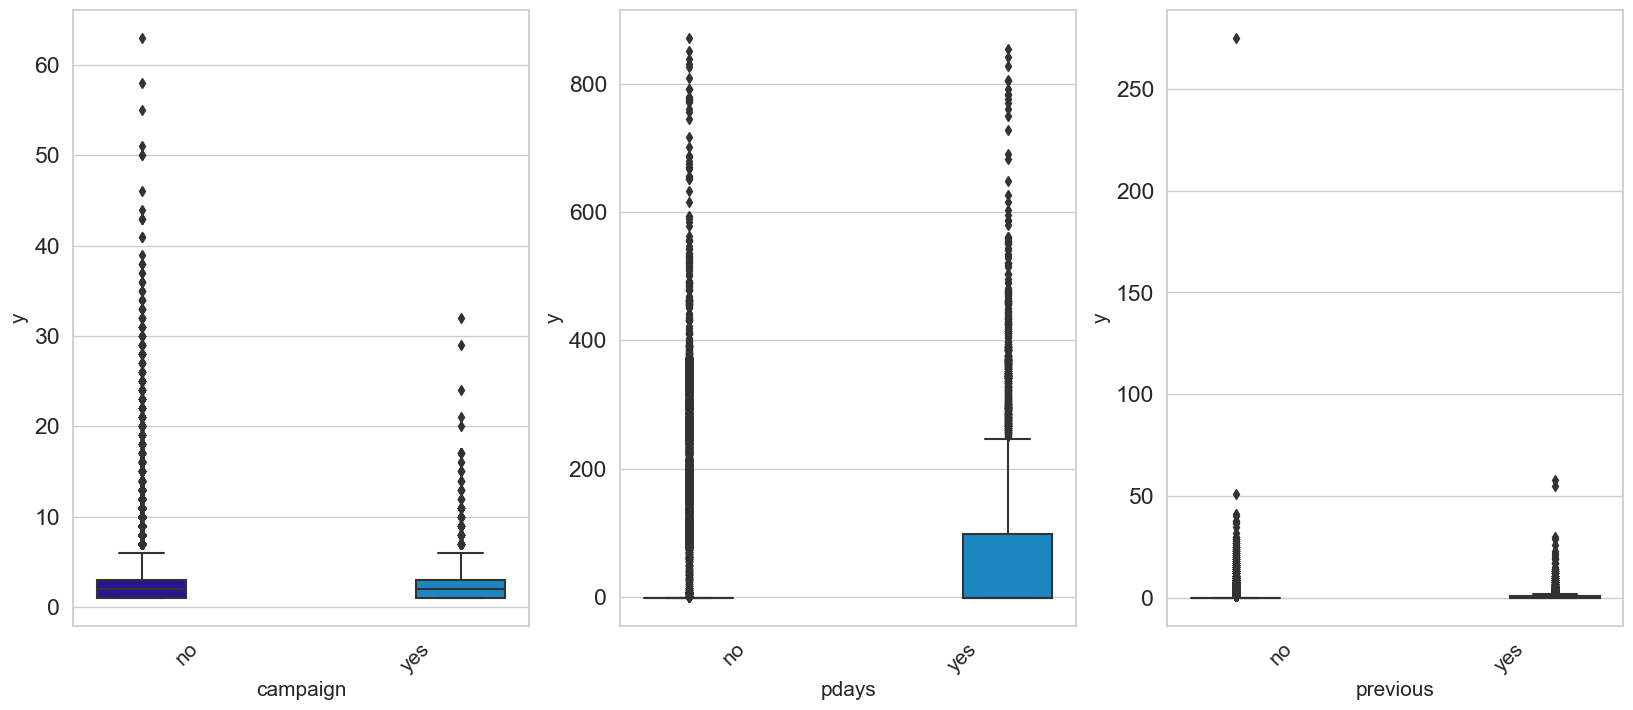

In [10]:
boxplot2(df,'y',numeric_features[4:],1,3,figsize=(20,8),xticks_size=15)

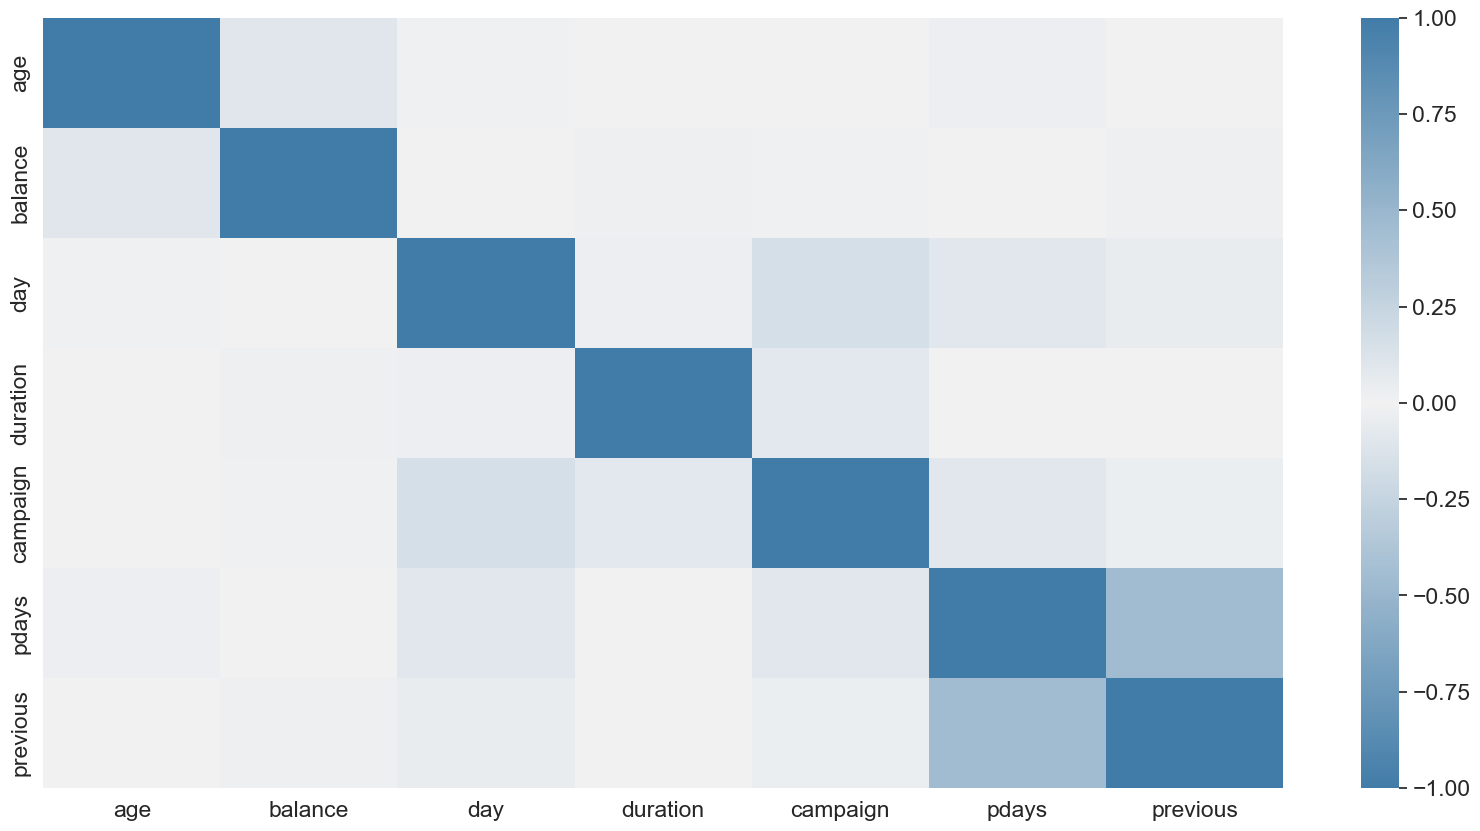

In [11]:
correlogram(df,col=numeric_features,figsize=(20,10))

Las variables no están correlacionadas, con excepción de **pdays** y **previous**, también tenemos variables con datos atípicos, en este caso es remendado utilizar un escalador robusto.

# **Preprocesamiento de los datos**

## **Definición de conjuntos de entrenamiento y prueba**

In [12]:
test_size = round(df.shape[0]*0.8)

df_sample = df.sample(df.shape[0],random_state=100)

train = df_sample.iloc[:test_size,:]
test =  df_sample.iloc[test_size:,:]

## **Definicion de features y target**

In [13]:
features = list(train.drop('y',axis=1).columns)
target = ['y']

# **Transformación de los datos** 

In [14]:
target_encoder = LabelEncoder()
num_scaler = RobustScaler()
cat_encoder = OneHotEncoder()

features_transformer = ColumnTransformer([
    ('numeric',num_scaler,numeric_features),
    ('categorical',cat_encoder,cat_features[:-1])
])

target_encoder.fit(train[target])
features_transformer.fit(train[features])

def transform_data(df):
    
    X = features_transformer.transform(df[features])
    y = target_encoder.transform(df[target])
    
    return X,y
    

In [15]:
X_train , y_train = transform_data(train)

X_test , y_test = transform_data(test)

## **Técnica de remuestreo para datos desbalanceados**

In [16]:
smoteen = SMOTEENN(random_state=100)
X_train, y_train = smoteen.fit_resample(X_train,y_train)

# **Elección del mejor modelo de red neuronal**

## **Arquitectura del modelo**

In [17]:
def nn_classifier(lr=0.05,opt='sgd',nn=10,n_hl=2,act='relu'):
    
    n_outputs = 1
    input_shape = (X_train.shape[1],)
    
    if opt == 'sgd':
        opt = SGD(learning_rate=lr)
        
    elif opt == 'adam':
        opt = Adam(learning_rate=lr)
        
    met = [AUC()]
    loss = BinaryCrossentropy()
    out_act = 'sigmoid'
    model = multi_layer_perceptron(input_shape,n_outputs,nn,n_hl,act,out_act,opt,loss,met)
    
    return model

## **Creación del hipermodelo**

In [18]:
class hyper_model(kt.HyperModel):
    
    def build(self, hp):
        
        lr_space = hp.Float('learning_rate',1e-4,0.9999,sampling='log')
        opt_space = hp.Choice('optimizer',['adam','sgd'])
        nn_space = hp.Int('number_neurons',1,100,sampling='log')
        hl_space = hp.Int('number_hidden_layers',1,10,sampling='log')
        act_space = hp.Choice('activation',['relu','sigmoid','tanh','elu'])
        model = nn_classifier(lr_space,opt_space,nn_space,hl_space,act_space)
        
        return model

## **Función objetivo y optimizador bayesiano**

In [19]:
hp = kt.HyperParameters()
mlp_hyper_model = hyper_model()

obj = kt.Objective("val_auc", direction="max")
bayesian_search = kt.BayesianOptimization(hypermodel=mlp_hyper_model,
                               objective=obj,
                               max_trials=50,
                               seed=1459,
                                directory='hyperparameter_results/',
                                project_name='Bank',
                                overwrite=True)

In [20]:
Epochs = 50
Batch_size = round(X_train.shape[0]/100)
Callbacks = [EarlyStopping(min_delta=1e-4,patience=3)]

In [20]:
bayesian_search.search(X_train,y_train,validation_data=(X_test,y_test),epochs=Epochs,
                       batch_size=Batch_size,callbacks=Callbacks)

Trial 50 Complete [00h 00m 05s]
val_auc: 0.9123799800872803

Best val_auc So Far: 0.9262468814849854
Total elapsed time: 00h 07m 12s
INFO:tensorflow:Oracle triggered exit


In [21]:
best_models_top5 = bayesian_search.get_best_models(5)
best_hp_top5 = bayesian_search.get_best_hyperparameters(5)

In [22]:
print('Best Params :\n',best_hp_top5[0].values)

Best Params :
 {'learning_rate': 0.0015240964443037862, 'optimizer': 'adam', 'number_neurons': 100, 'number_hidden_layers': 4, 'activation': 'elu'}


In [23]:
print('Second Best Params :\n',best_hp_top5[1].values)

Second Best Params :
 {'learning_rate': 0.00291261095002293, 'optimizer': 'adam', 'number_neurons': 100, 'number_hidden_layers': 1, 'activation': 'elu'}


In [24]:
print('Third Best Params :\n',best_hp_top5[2].values)

Third Best Params :
 {'learning_rate': 0.0011537225830584995, 'optimizer': 'adam', 'number_neurons': 67, 'number_hidden_layers': 3, 'activation': 'tanh'}


In [25]:
print('Fourth Best Params :\n',best_hp_top5[4].values)

Fourth Best Params :
 {'learning_rate': 0.0155187450770208, 'optimizer': 'adam', 'number_neurons': 48, 'number_hidden_layers': 1, 'activation': 'tanh'}


In [26]:
best_models_top5[0].save('models/bank_best_model.h5')

El mejor modelo obtuvo un valor del $AIC = 0.926$, con una tasa de aprendizaje de 0.069, usando el optimizador $adam$, 100 neuronas en cada capa oculta, una sola capa oculta y función de activación $elu$.

# **Modelo reduciendo la dimención mediante el PCA**

In [27]:
pca = PCA()
pca.fit(X_train)

PCA()

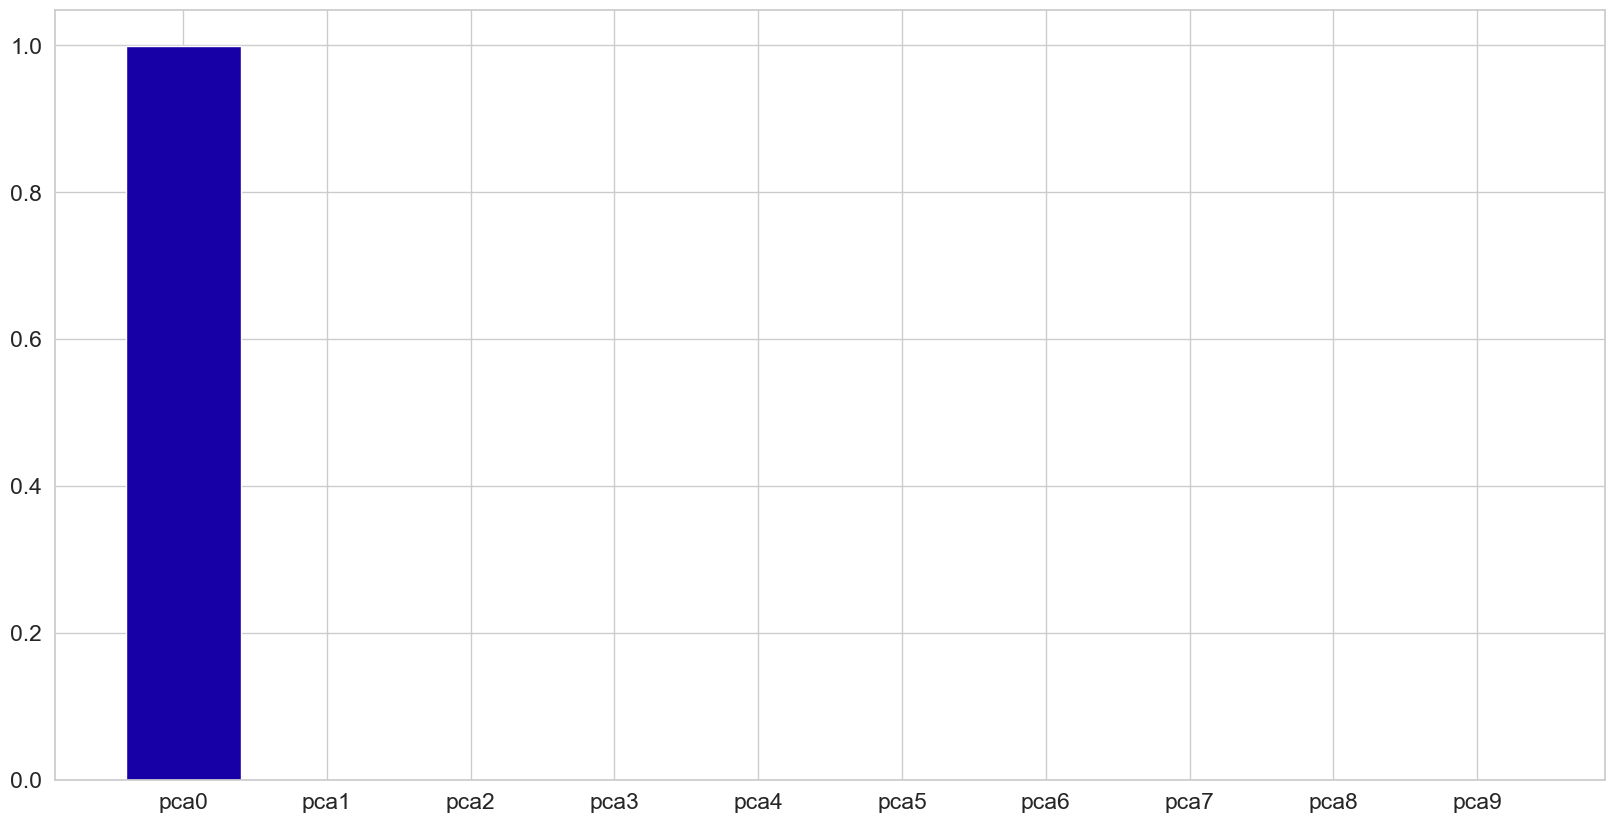

In [28]:
plt.figure(figsize=(20,10))
plt.bar(x=pca.get_feature_names_out()[:10],height=pca.explained_variance_ratio_[:10])
plt.show()

In [29]:
X_train_pca = pca.transform(X_train)[:,:25]
X_test_pca = pca.transform(X_test)[:,:25]

In [33]:
def nn_classifier_pca(lr=0.05,nn=10,n_hl=2,act='relu'):
    
    n_outputs = 1
    input_shape = (X_train_pca.shape[1],)
    
    opt = Adam(learning_rate=lr)
        
    met = [AUC()]
    loss = BinaryCrossentropy()
    out_act = 'sigmoid'
    model = multi_layer_perceptron(input_shape,n_outputs,nn,n_hl,act,out_act,opt,loss,met)
    
    return model

class hyper_model_pca(kt.HyperModel):
    
    def build(self, hp):
        
        lr_space = hp.Float('learning_rate',1e-4,0.1,sampling='log')
        nn_space = hp.Int('number_neurons',1,100,sampling='log')
        hl_space = hp.Int('number_hidden_layers',1,5,sampling='log')
        act_space = hp.Choice('activation',['relu','sigmoid','tanh','elu'])
        model = nn_classifier_pca(lr_space,nn_space,hl_space,act_space)
        
        return model

hp_pca = kt.HyperParameters()
mlp_hyper_model_pca = hyper_model_pca()

obj_pca = kt.Objective("val_auc", direction="max")
bayesian_search_pca = kt.BayesianOptimization(hypermodel=mlp_hyper_model_pca,
                               objective=obj_pca,
                               max_trials=50,
                               seed=145,
                                directory='hyperparameter_results/',
                                project_name='Bank_PCA',
                                overwrite=True)

In [34]:
Epochs = 50
Batch_size = round(X_train.shape[0]/100)
Callbacks = [EarlyStopping(min_delta=1e-4,patience=4)]

In [35]:
bayesian_search_pca.search(X_train_pca,y_train,validation_data=(X_test_pca,y_test),epochs=Epochs,
                       batch_size=Batch_size,callbacks=Callbacks)

Trial 50 Complete [00h 00m 04s]
val_auc: 0.919309139251709

Best val_auc So Far: 0.9235557317733765
Total elapsed time: 00h 06m 26s
INFO:tensorflow:Oracle triggered exit


In [36]:
params_top5_pca = bayesian_search_pca.get_best_hyperparameters(5)

In [37]:
print('Best Params :\n',params_top5_pca[0].values)

Best Params :
 {'learning_rate': 0.01951642572859409, 'number_neurons': 100, 'number_hidden_layers': 4, 'activation': 'elu'}


In [38]:
print('Second Best Params :\n',params_top5_pca[1].values)

Second Best Params :
 {'learning_rate': 0.020998740604693658, 'number_neurons': 100, 'number_hidden_layers': 4, 'activation': 'elu'}


In [39]:
best_model_pca = bayesian_search_pca.get_best_models(1)

In [40]:
best_model_pca[0].save('models/bank_best_model_pca.h5')

El mejor modelo obtuvo un valor del $AIC = 0.919$, con una tasa de aprendizaje de 0.028, usando el optimizador $adam$, 16 neuronas en cada capa oculta, dos capas ocultas y función de activación $elu$.